A 'matching' quasi-experimental design controls for confounder variables $x$ by estimating what the control outcomes $y$ would be if the control population had the same values of $x$ as the treatment population. To do this, we regress outcomes in the control population on $x$, and apply this regression model to the treatment population's confounder distribution.

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import numpyro
numpyro.set_host_device_count(4)
import pyro_util
import pandas as pd
import numpy as np
import numpyro.distributions as dist
import arviz as az
import xarray as xr
import seaborn as sns
import preliz as pz
from scipy.stats import zscore
import jax.numpy as jnp

The book [Causal Inference: The Mixtable](https://mixtape.scunning.com/) describes the problem of estimating the effect on fugure earnings of attending a job training program, specifically the National Supported Work Demonstration program established by the US government in the '70s. We want to compare changes in earnings for those who enrolled in the program to changes in earnings of the general US population as reported by the Current Population Survey. By using the matching model above, we can control for the fact that those who enrolled in the program were generally less educated and younger than the overall population. The analysis below deviates substantially from that described in the book. 

In [2]:
cps = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/cps_mixtape.dta")
nsw = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/nsw_mixtape.dta")
df = pd.concat([nsw, cps])
df['treated'] = df.treat == 1.0
df['improvement'] = df.re78 - df.re75

This plot shows that the treated population is younger on average. 

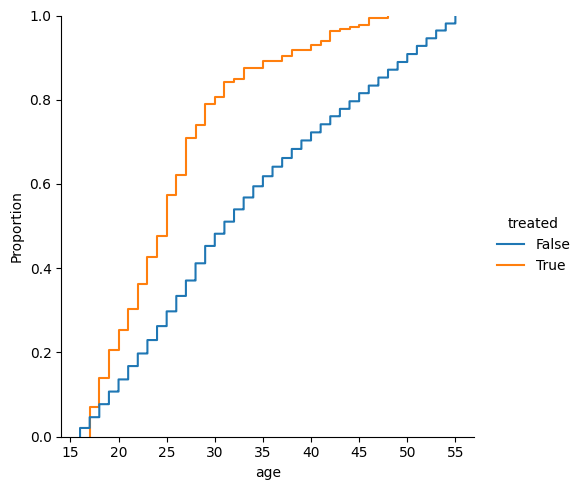

In [3]:
sns.displot(df, x="age", hue="treated", kind='ecdf');

This plot shows how they're less educated as well. 

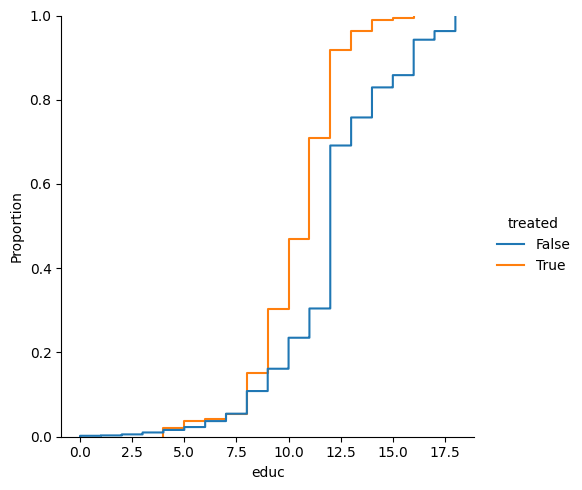

In [4]:
sns.displot(df, x="educ", hue="treated", kind='ecdf');

The plot below shows that education is a confounder, affecting both treatment and improvement.

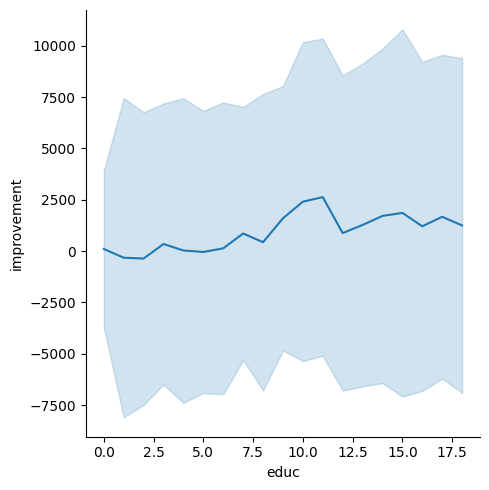

In [6]:
sns.relplot(df, x="educ", y="improvement", kind="line", errorbar="sd");

The same is true for age:

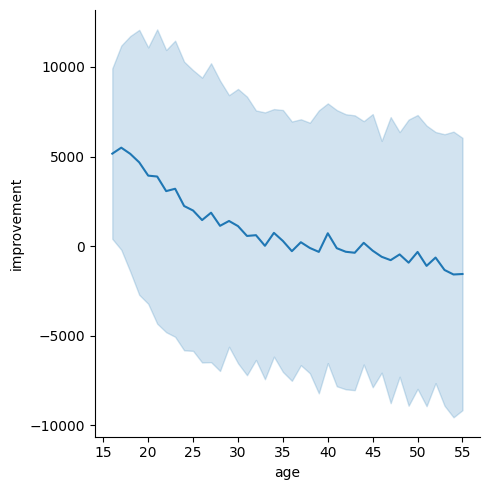

In [7]:
sns.relplot(df, x="age", y="improvement", kind="line", errorbar="sd");

As treated participants are more likely to be younger and younger participants generally showed more improvement, naively taking a difference between the populations' improvements might over-estimate the true effect of the program on the treated population. At the same time, the treatment group was also less educated and we saw more improvement among more educated people, so a naive difference might under-estimate the true effect as well. We control for both of these confounders by using a Gaussian process to predict the improvements the treatment population would have had had they not been treated. 

I'l use RBF kernels in the GP. These kernels will have a loose prior over lengthscales wide enough to account for any of the distances observed in the data.

In [8]:
def lengthscale_params(xs):
    x_vals = xs.to_numpy()
    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    nz = differences[differences != 0]
    l_b = np.quantile(nz, 0.025)
    u_b = np.quantile(nz, 0.975)
    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, 0.95, plot=False)
    return dist.params

A quick glance at the improvment distribution suggests that we need to model a zero-improvement outcome as a special case. I'll only sample from the Gaussian Process if the latent 'unimproved' Bernoulli $z$ is true. 

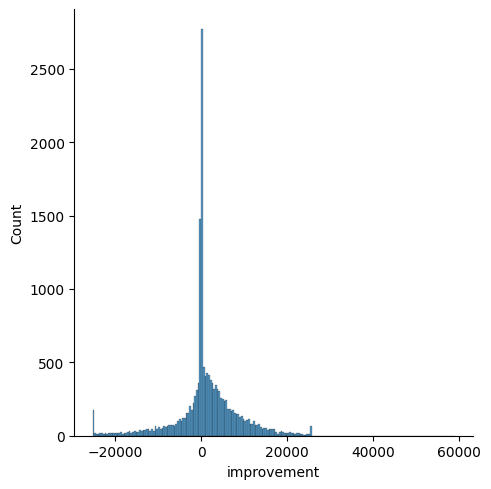

In [9]:
sns.displot(df, x="improvement")

In [10]:
df["unimproved"] = df.improvement == 0

It seems like a lack of improvement is slightly correlated with education and age.

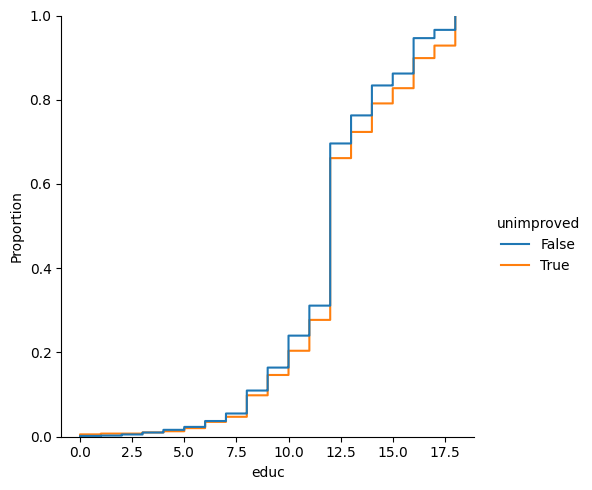

In [15]:
sns.displot(df, x="educ", hue="unimproved", kind='ecdf')

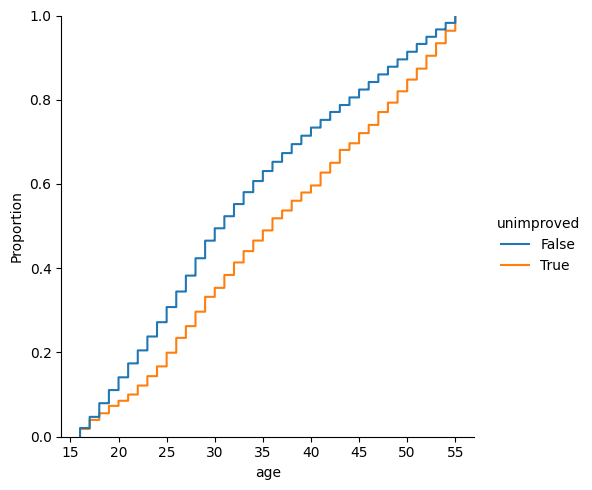

In [16]:
sns.displot(df, x="age", hue="unimproved", kind='ecdf')

Together, these observations lead to the following model:

In [ ]:
def matching_model():
    control = df[~df.treated]
    f, f_control = pyro_util.hsgp_rbf(
        control, "zscore(age) + zscore(educ)")
    unimproved_model, mask = pyro_util.glm(
        control, "unimproved ~ zscore(age) + zscore(educ)", family=dist.Bernoulli)
    sigma = numpyro.sample("sigma", dist.HalfNormal(control.improvement.std())
    numpyro.sample("y0", dist.Normal(loc=f_control[mask], scale=sigma), obs=control.improvement[mask])
    treated = df[df.treated]
    numpyro.deterministic("effect", treated.improvement.mean() - (f.at(treated) * p.at(treated)).mean())

In [ ]:
mcmc = pyro_util.fit_nuts(model, num_samples=1500)

In [18]:
results = pyro_util.from_numpyro(df, model, mcmc, predictive=False)

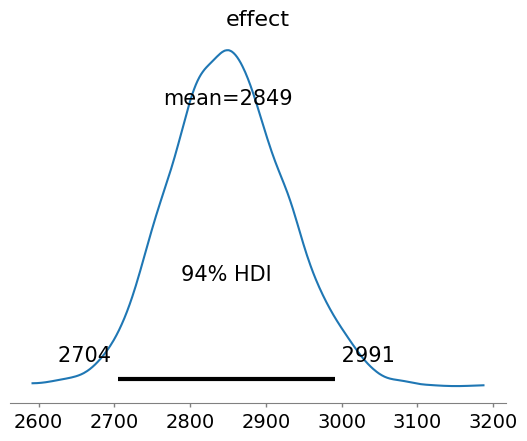

In [89]:
az.plot_posterior(results, var_names="effect");


The matching model estimates that the job training program led to between 2704 and 2991 in additional inflation adjusted earnings, which is, as we suspected, lower than a naive difference of means would suggest. 

In [91]:
(df[df.treated]['improvement']).mean() - (df[~df.treated]['improvement']).mean()

3587.7637

## The GP Interface

In the model above I used the function `pyro_util.hsgp_rbf`, which I defined as follows:

In [96]:
from collections import namedtuple
from typing import Union

class hsgp(namedtuple("hsgp", "spd beta ell m")):
    __slots__ = ()
    def at(self, x):
        phi = eigenfunctions(x=x, ell=self.ell, m=self.m)
        return phi @ (self.spd * self.beta)

def hsgp_rbf(
    prefix: str,
    alpha: float,
    ell: float,
    m: int,
    length: Union[float,list[float]]) -> hsgp:
    dim = len(length) if hasattr(length.__class__, "__len__") else 1
    spd = jnp.sqrt(diag_spectral_density_squared_exponential(
            alpha=alpha, length=length, ell=ell, m=m, dim=dim))
    with handlers.scope(prefix=prefix):
        with numpyro.plate("basis", len(spd)):
            beta = numpyro.sample("beta", dist.Normal())
    return hsgp(spd, beta, ell, m)

This allows me to reference the same Gaussian Process "f" multiple times within my model above, unlike the `hsgp_squared_exponential` function currently within Numpyro.